In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split

from models import MobileNetV3

from data_preparation import CreateDataset,\
                             load_images_and_labels, \
                             encode_labels, \
                             create_data_augmentation

from trainer import train_model, \
                    plot_losses, \
                    evaluate_model

import boto3
import multiprocessing

num_workers = multiprocessing.cpu_count()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
BATCH_SIZE = 128

In [4]:
data = "fer2013"
bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [5]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [6]:
# label_encoder, y_train, y_test = encode_labels(y_train, y_test)
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)


In [7]:
transform = create_data_augmentation()

In [8]:
train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [10]:
model = MobileNetV3(num_labels=len(label_encoder.classes_))
model.to(device)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [11]:
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss()

best_model, train_losses, val_losses = train_model(
                                    model=model,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    device=device,
                                    epochs=500,
                                    patience=10
                                )

100%|██████████| 141/141 [00:32<00:00,  4.40it/s]


Epoch 1, Train Loss: 1.6163, Validation Loss: 1.5475


100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


Epoch 2, Train Loss: 1.3544, Validation Loss: 1.3682


100%|██████████| 141/141 [00:31<00:00,  4.50it/s]


Epoch 3, Train Loss: 1.2548, Validation Loss: 1.3141


100%|██████████| 141/141 [00:31<00:00,  4.48it/s]


Epoch 4, Train Loss: 1.1806, Validation Loss: 1.2556


100%|██████████| 141/141 [00:31<00:00,  4.44it/s]


Epoch 5, Train Loss: 1.1281, Validation Loss: 1.1583


100%|██████████| 141/141 [00:31<00:00,  4.50it/s]


Epoch 6, Train Loss: 1.0851, Validation Loss: 1.1361


100%|██████████| 141/141 [00:31<00:00,  4.46it/s]


Epoch 7, Train Loss: 1.0491, Validation Loss: 1.1039


100%|██████████| 141/141 [00:31<00:00,  4.53it/s]


Epoch 8, Train Loss: 1.0165, Validation Loss: 1.1082


100%|██████████| 141/141 [00:31<00:00,  4.51it/s]


Epoch 9, Train Loss: 0.9848, Validation Loss: 1.0886


100%|██████████| 141/141 [00:31<00:00,  4.46it/s]


Epoch 10, Train Loss: 0.9565, Validation Loss: 1.0803


100%|██████████| 141/141 [00:31<00:00,  4.48it/s]


Epoch 11, Train Loss: 0.9345, Validation Loss: 1.0787


100%|██████████| 141/141 [00:31<00:00,  4.50it/s]


Epoch 12, Train Loss: 0.9069, Validation Loss: 1.0619


100%|██████████| 141/141 [00:31<00:00,  4.52it/s]


Epoch 13, Train Loss: 0.8805, Validation Loss: 1.0626


100%|██████████| 141/141 [00:31<00:00,  4.53it/s]


Epoch 14, Train Loss: 0.8554, Validation Loss: 1.0733


100%|██████████| 141/141 [00:31<00:00,  4.50it/s]


Epoch 15, Train Loss: 0.8275, Validation Loss: 1.0763


100%|██████████| 141/141 [00:31<00:00,  4.42it/s]


Epoch 16, Train Loss: 0.8094, Validation Loss: 1.0656


100%|██████████| 141/141 [00:31<00:00,  4.50it/s]


Epoch 17, Train Loss: 0.7852, Validation Loss: 1.0756


100%|██████████| 141/141 [00:31<00:00,  4.50it/s]


Epoch 18, Train Loss: 0.7649, Validation Loss: 1.0853


100%|██████████| 141/141 [00:31<00:00,  4.51it/s]


Epoch 19, Train Loss: 0.7336, Validation Loss: 1.0909


100%|██████████| 141/141 [00:31<00:00,  4.48it/s]


Epoch 20, Train Loss: 0.7143, Validation Loss: 1.1030


100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


Epoch 21, Train Loss: 0.6848, Validation Loss: 1.1323


100%|██████████| 141/141 [00:31<00:00,  4.51it/s]


Epoch 22, Train Loss: 0.6711, Validation Loss: 1.1411
Early stopping triggered


In [12]:
# Save the model to a local path
model_dir = f'{data}/models'

model_path = f'mobilenetv3_{data}_best_model.pt'
torch.save(model.state_dict(), model_path)

# Upload the model to S3
s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

os.remove(model_path)

In [13]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

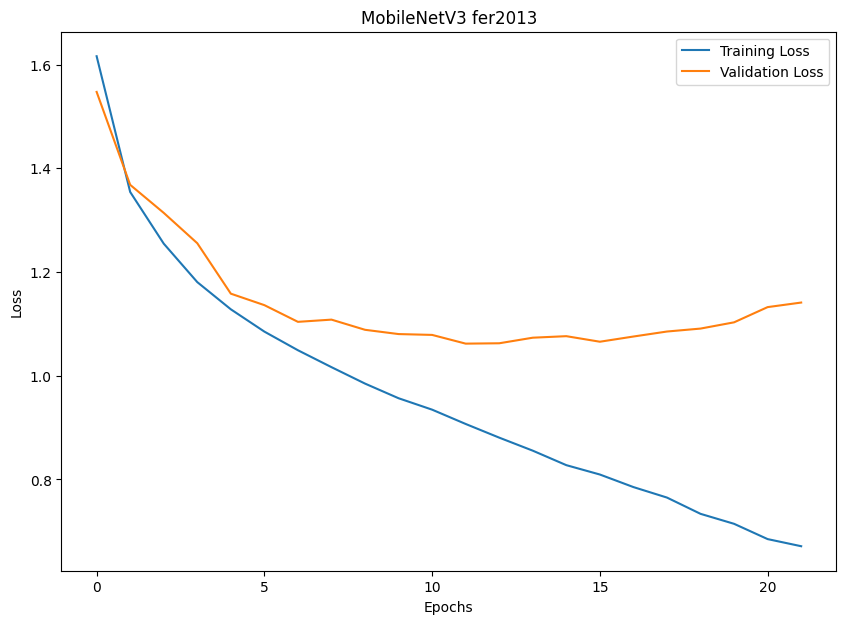

In [14]:
plot_losses(train_losses, val_losses, title=f"MobileNetV3 {data}")

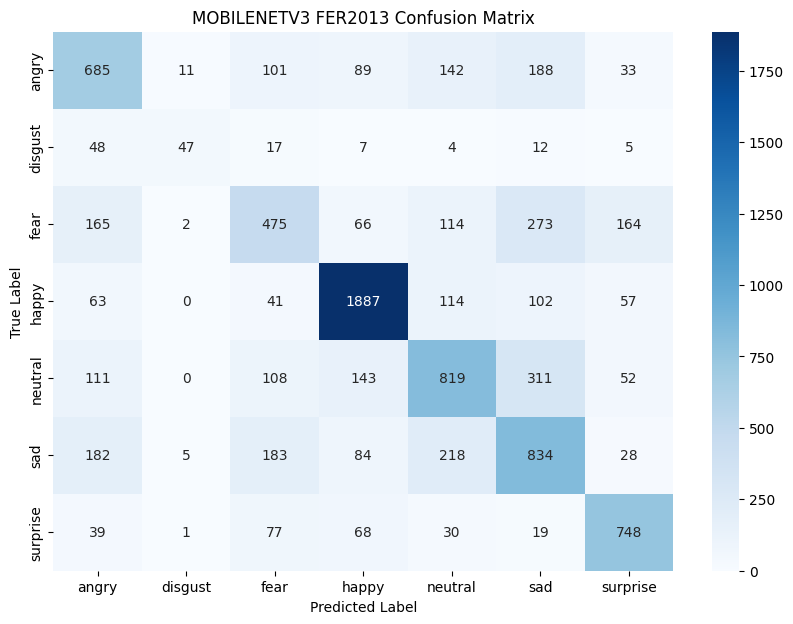

Test Accuracy: 0.6125
Precision: 0.6082
Recall: 0.5615
F1 Score: 0.5737
Classification Report:
               precision    recall  f1-score   support

       angry       0.53      0.55      0.54      1249
     disgust       0.71      0.34      0.46       140
        fear       0.47      0.38      0.42      1259
       happy       0.81      0.83      0.82      2264
     neutral       0.57      0.53      0.55      1544
         sad       0.48      0.54      0.51      1534
    surprise       0.69      0.76      0.72       982

    accuracy                           0.61      8972
   macro avg       0.61      0.56      0.57      8972
weighted avg       0.61      0.61      0.61      8972



In [15]:
evaluate_model(model=model,
               test_loader=test_loader,
               device=device,
               data=f"MobileNetV3 {data}",
               label_encoder=label_encoder)